The 3 Models are:
- MobileNet
- ShuffleNet
- EfficientNet

# Device Information


In [1]:
! lsblk -io KNAME,TYPE,SIZE,MODEL #disk

KNAME TYPE   SIZE MODEL
sda   disk 388.4M Virtual Disk
sdb   disk    16G Virtual Disk
sdc   disk     1T Virtual Disk


In [2]:
_ = ! apt install lshw #CPU
! lshw

achmadbauravindah           
    description: Computer
    width: 64 bits
    capabilities: smp vsyscall32
  *-core
       description: Motherboard
       physical id: 0
     *-memory
          description: System memory
          physical id: 1
          size: 64GiB
     *-cpu
          product: 12th Gen Intel(R) Core(TM) i9-12900
          vendor: Intel Corp.
          physical id: 2
          bus info: cpu@0
          version: 6.151.2
          width: 64 bits
          capabilities: fpu fpu_exception wp vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp x86-64 constant_tsc rep_good nopl xtopology tsc_reliable nonstop_tsc cpuid pni pclmulqdq vmx ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp ibrs_enhanced tpr_shadow vnmi ept vpid ept_ad fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpci

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  4 14:00:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.51.01              Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:01:00.0 Off |                  N/A |
|  0%   43C    P8             25W /  320W |     529MiB /  10240MiB |     33%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Welcome to Thoracic Abnormalities Detection with Mobile Model


Dataset: Online Dataset
<br>
<br>
Dataset Reference: https://vindr.ai/datasets/cxr

### Connect Google Drive

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

### Import All Requirements Library

In [5]:
# Full Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Dropout, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, SeparableConv2D, Add, GlobalAveragePooling2D, Dense, Flatten, AveragePooling2D, Lambda, Rescaling
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras import Model
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import Callback

# MISC
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
# import gdown
from datetime import datetime
import os
import glob

2024-12-04 14:00:25.113064: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 14:00:25.121342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733288425.130916  564112 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733288425.133654  564112 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 14:00:25.145148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [6]:
# Install Writer Excel (Untuk dokumentasi hasil pelatihan)
_ = ! pip install xlsxwriter

### Set Dataset Path

In [7]:
parent_dir = "../Code - Thoracic Abnormalities (only Windows)/"

In [8]:
# Drive
EXCEL_FILENAME = "Split_NIH_ThoracicAbnotmalities_Dataset.xlsx"

In [9]:
# # Download Dataset in zip, this happen because more efficient to load npy npy images
# def download_dataset(id_url):
#     # Download Folder from Another Account Shared Folder
#     url = "https://drive.google.com/uc?id=" + id_url
#     # file_output = "Rice Leafs Dataset (Preprocessed).zip"
#     file_output = "NIH Thoracic Dataset (Filtered).zip"
#     gdown.download(url, file_output, quiet=False)

#     # _ = ! unzip "Rice Leafs Dataset (Preprocessed).zip" # unzip if data zipped
#     _ = ! unzip "NIH Thoracic Dataset (Filtered).zip" # unzip if data zipped

# id_url = "1sAwTqnYk92MWnkWvYGJsPetIvfNPH_E-"
# download_dataset(id_url)

### Initiate Labels (Abnormalities)

In [10]:
meta_data_df = pd.read_excel(EXCEL_FILENAME)
selected_labels = meta_data_df.columns[2:]
selected_labels

Index(['atelectasis', 'cardiomegaly', 'effusion', 'pneumothorax',
       'nodule/mass'],
      dtype='object')

### Show 1 Sample Image

Sample Image
Images Path: ../Code - Thoracic Abnormalities (only Windows)/NIH Original Dataset/images_006/images/00012326_000.png
LABEL: ['pneumothorax']


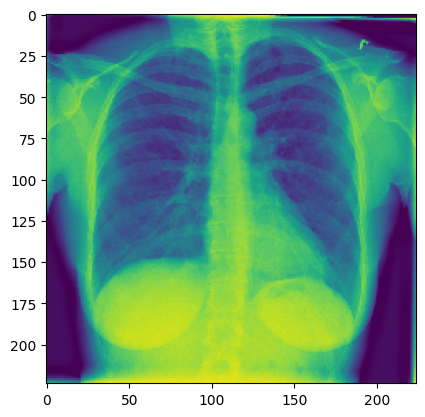

In [11]:
root_directory = "../Code - Thoracic Abnormalities (only Windows)/NIH Original Dataset" # If you in Google Colab,  change the root directory
# root_directory = "data
image_name = meta_data_df['Image Index'][30]
sample_image = glob.glob(f"{root_directory}/**/{image_name}", recursive=True)[0]
# Show label
row = meta_data_df.iloc[30, 2:]
labels = row[row == 1].index.tolist()

print("Sample Image")
print("Images Path: {}".format(sample_image))
fig, axes = plt.subplots(1, 1)
_ = axes.imshow(img_to_array(load_img(sample_image, target_size=(224, 224), color_mode='grayscale')).astype('uint8'))
print("LABEL:", labels)

# MobileNet Model


In [12]:
class MobileNet_Model(Model):
    def __init__(self):
        pass

    def custom_net_layers(self, inputs):
        custom_net_model = tf.keras.applications.MobileNet(
                                                        include_top=False,
                                                        weights='imagenet',
                                                        input_tensor=inputs,
                                                        input_shape=(224, 224, 3),
                                                        pooling='max')
        custom_layers = custom_net_model.output
        return custom_layers



    def call(self, inputs):
        # MobileNet Layers
        custom_net_layers = self.custom_net_layers(inputs)

        # FCL Classifier
        outputs = Dense(5, activation='sigmoid')(custom_net_layers)
        return outputs

def buildModelMobileNet():
    global MobileNet_Model
    # MODEL BUILDING
    input_shape = (224, 224, 3)
    input_layer = Input(shape=input_shape, name='input_layer')
    build_model = MobileNet_Model()
    output_layer = build_model.call(input_layer)

    # Final Model
    model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
    learning_rate = 0.0001
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile Model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ShuffleNet Models, I will try xception first

In [13]:
class Xception_Model(Model):
    def __init__(self):
        pass

    def custom_net_layers(self, inputs):
        custom_net_model = tf.keras.applications.Xception(
                                                        include_top=False,
                                                        weights=None,
                                                        input_tensor=inputs,
                                                        input_shape=(224, 224, 3),
                                                        pooling='avg')
        custom_layers = custom_net_model.output
        return custom_layers



    def call(self, inputs):
        # Xception Layers
        custom_net_layers = self.custom_net_layers(inputs)

        # FCL Classifier
        outputs = Dense(5, activation='sigmoid')(custom_net_layers)
        return outputs

def buildModelXception():
    global Xception_Model
    # MODEL BUILDING
    input_shape = (224, 224, 3)
    input_layer = Input(shape=input_shape, name='input_layer')
    build_model = Xception_Model()
    output_layer = build_model.call(input_layer)

    # Final Model
    model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
    learning_rate = 0.001
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile Model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model




# EfficientNet Model


In [14]:
# class EfficientNetB0_Model(Model):
#     def __init__(self):
#         pass

#     def custom_net_layers(self, inputs):
#         custom_net_model = tf.keras.applications.EfficientNetB0(
#                                                         include_top=False,
#                                                         weights='imagenet',
#                                                         input_tensor=inputs,
#                                                         input_shape=(224, 224, 3),
#                                                         pooling='avg',
#                                                         classes=3)
#         custom_layers = custom_net_model.output
#         return custom_layers



#     def call(self, inputs):
#         # EfficientNetB0 Layers
#         custom_net_layers = self.custom_net_layers(inputs)

#         # FCL Classifier
#         outputs = Dense(3, activation='softmax')(custom_net_layers)
#         return outputs

# def buildModelEfficientNetB0():
#     global EfficientNetB0_Model
#     # MODEL BUILDING
#     input_shape = (224, 224, 3)
#     input_layer = Input(shape=input_shape, name='input_layer')
#     build_model = EfficientNetB0_Model()
#     output_layer = build_model.call(input_layer)

#     # Final Model
#     model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
#     learning_rate = 0.001
#     optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

#     # Compile Model
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

### Get Images Array from Filepath in Excel

In [15]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def get_file_path_map(root_directory):
    """
    Pre-index all file paths in the root directory for faster lookups.
    """
    file_map = {}
    for root, _, files in os.walk(root_directory):
        for file in files:
            file_map[file] = os.path.join(root, file)
    return file_map

def load_and_process_image(image_path):
    """
    Load and process a single image given its path.
    """
    try:
        image_arr = img_to_array(load_img(image_path, target_size=(224, 224), color_mode='rgb')) / 255.0
        return image_arr
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def getArrFromExcel(sheet_name):
    # Get Labels
    meta_data_df = pd.read_excel(EXCEL_FILENAME, sheet_name=sheet_name)
    image_names = meta_data_df['Image Index']
    labels = meta_data_df.iloc[:, 2:]

    # Build a file path map for faster lookups
    root_directory = "../Code - Thoracic Abnormalities (only Windows)/NIH Original Dataset" # If you in Google Colab,  change the root directory
    file_path_map = get_file_path_map(root_directory)

    # Prepare to store image arrays
    images_arr = []

    # Use ThreadPoolExecutor for parallel image loading
    with ThreadPoolExecutor() as executor:
        future_to_image = {executor.submit(load_and_process_image, file_path_map[image_name]): image_name
                           for image_name in image_names if image_name in file_path_map}

        for future in tqdm(future_to_image, total=len(future_to_image), desc="Processing images"):
            result = future.result()
            if result is not None:
                images_arr.append(result)

    return np.array(images_arr), labels

In [16]:
# # Example
# train_sheet_name_per_fold = "fold_1_val"
# train_images_arr, labels = getArrFromExcel(train_sheet_name_per_fold)
# train_images_arr.shape

### Model Training with K-Fold

# ---MobileNet Training---

In [17]:
# model = buildModelMobileNet()
# model.summary()

In [18]:
n_sheets_excel = len(pd.ExcelFile(EXCEL_FILENAME).sheet_names)
n_k_fold = int((n_sheets_excel - 1) / 2)

# Drive Path
# base_path = "/content/drive/MyDrive/Research - Thoracic Abnormalities/Models Evaluation/MobileNet/training/"
# Local Path
model_name = "MobileNet"
base_path = f"../Models Evaluation/{model_name}/training/"

# Function to create a unique directory for each run
def create_run_dir(base_path):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_path = os.path.join(base_path, f"run_{timestamp}")
    os.makedirs(run_path, exist_ok=True)
    return run_path

# Function to dynamically extract hyperparameters/other info from the model
def get_model_hyperparameters(model, batch_size, epochs, train_images_arr, val_images_arr, train_labels):
    test_size = len(pd.read_excel(EXCEL_FILENAME, sheet_name='test'))
    all_images_count = len(train_images_arr) + len(val_images_arr) + test_size
    return {
        "model_name": model_name,
        "images_count": all_images_count,
        "image_size": train_images_arr[0].shape if isinstance(train_images_arr, np.ndarray) else "N/A",
        "num_labels": len(train_labels.iloc[0]),
        "epochs": epochs,
        "optimizer": model.optimizer.get_config()["name"],  # Extract optimizer name
        "learning_rate": model.optimizer.learning_rate.numpy() if hasattr(model.optimizer, "learning_rate") else "N/A",  # Get learning rate
        "loss": model.loss if hasattr(model, "loss") else "N/A",  # Extract loss function
        "batch_size": batch_size,
    }

# Create a unique directory for the current program run
run_path = create_run_dir(base_path)

for k in range(1, n_k_fold + 1):
    print("##################### FOLD - {} #####################".format(k))

    # Create a directory for the current fold within the run directory
    fold_path = os.path.join(run_path, f"fold_{k}")
    os.makedirs(fold_path, exist_ok=True)
    
    # CALLBACK
    # CSV Logger Callback
    csv_logger_filename = base_path + 'csv_loggers/csv_logger_fold_{}.csv'.format(k)
    csv_logger_callback = CSVLogger(csv_logger_filename)

    # Sheet Name
    train_sheet_name_per_fold = "fold_{}_train".format(k)
    val_sheet_name_per_fold = "fold_{}_val".format(k)
    # Get Array Images and Masks
    train_images_arr, train_labels = getArrFromExcel(train_sheet_name_per_fold)
    val_images_arr, val_labels = getArrFromExcel(val_sheet_name_per_fold)

    # Build Model
    model = buildModelMobileNet()
    
    # Dynamically extract hyperparameters
    batch_size = 8
    epochs = 50
    hyperparams = get_model_hyperparameters(model, batch_size, epochs, train_images_arr, val_images_arr, train_labels)

    # Model Training
    history = model.fit(train_images_arr,
                        train_labels,
                        validation_data=(val_images_arr, val_labels),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=csv_logger_callback)
    

    # Append training history summary to the .csv log file
    csv_logger_filename_summary = os.path.join(fold_path, f'summary_log_fold_{k}.csv')
    # Extract the last epoch's metrics
    last_epoch_metrics = {metric: values[-1] for metric, values in history.history.items()}
    # Convert the metrics dictionary to a DataFrame
    last_epoch_df = pd.DataFrame([last_epoch_metrics])
    # Add fold-specific hyperparameters to the DataFrame for context
    hyperparams_df = pd.DataFrame([hyperparams])
    # Combine metrics and hyperparameters into one DataFrame
    summary_df = pd.concat([last_epoch_df, hyperparams_df], axis=1)
    # Save to CSV
    summary_df.to_csv(csv_logger_filename_summary, index=False)

    # Read CSV Logger After Training
    csv_logger_df = pd.read_csv(csv_logger_filename)
    csv_logger_df.to_csv(csv_logger_filename)
    
    # Write hyperparameters and other details to a .txt log file
    # with open(txt_logger_filename, 'w') as txt_logger:

    # Model Per Fold Documentation
    model.save(base_path + "model_per_fold/model_fold_{}.h5".format(k))

##################### FOLD - 1 #####################


Processing images: 100%|██████████| 1840/1840 [00:03<00:00, 577.93it/s]
I0000 00:00:1733288449.143426  564112 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/50


/root/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(
I0000 00:00:1733288459.045181  564407 service.cc:148] XLA service 0x7fc810014e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733288459.045212  564407 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-12-04 14:00:59.185031: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733288459.854091  564407 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/920 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.3295 - loss: 2.8258

I0000 00:00:1733288466.448498  564407 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


917/920 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3038 - loss: 0.9225

/root/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.3039 - loss: 0.9218 - val_accuracy: 0.3870 - val_loss: 0.7178
Epoch 2/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4331 - loss: 0.5788 - val_accuracy: 0.3967 - val_loss: 0.6400
Epoch 3/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5158 - loss: 0.4778 - val_accuracy: 0.4750 - val_loss: 0.5795
Epoch 4/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5827 - loss: 0.4132 - val_accuracy: 0.4054 - val_loss: 0.6419
Epoch 5/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6198 - loss: 0.3680 - val_accuracy: 0.4609 - val_loss: 0.6238
Epoch 6/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6588 - loss: 0.3380 - val_accuracy: 0.5049 - val_loss: 0.5889
Epoch 7/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6919 - loss: 0.2926 - val_accuracy: 0.4984 - val_loss: 0.5911
Epoch 8/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7185 - loss: 0.2536 - val_accuracy: 0.4859 -

##################### FOLD - 2 #####################


Processing images: 100%|██████████| 1840/1840 [00:03<00:00, 530.42it/s]


Epoch 1/50


/root/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


917/920 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3048 - loss: 0.9184

/root/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.3049 - loss: 0.9177 - val_accuracy: 0.3745 - val_loss: 0.7109
Epoch 2/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4530 - loss: 0.5516 - val_accuracy: 0.4299 - val_loss: 0.5573
Epoch 3/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5209 - loss: 0.4556 - val_accuracy: 0.4788 - val_loss: 0.5366
Epoch 4/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5739 - loss: 0.4176 - val_accuracy: 0.4859 - val_loss: 0.5500
Epoch 5/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6000 - loss: 0.3839 - val_accuracy: 0.4685 - val_loss: 0.5431
Epoch 6/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6267 - loss: 0.3489 - val_accuracy: 0.4511 - val_loss: 0.5953
Epoch 7/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6772 - loss: 0.3119 - val_accuracy: 0.4299 - val_loss: 0.5925
Epoch 8/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7079 - loss: 0.2802 - val_accuracy: 0.

##################### FOLD - 3 #####################


Processing images: 100%|██████████| 1840/1840 [00:03<00:00, 545.04it/s]


Epoch 1/50


/root/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


917/920 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3106 - loss: 1.1122

/root/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.3108 - loss: 1.1109 - val_accuracy: 0.3701 - val_loss: 0.6749
Epoch 2/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4488 - loss: 0.5672 - val_accuracy: 0.4587 - val_loss: 0.6218
Epoch 3/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5303 - loss: 0.4726 - val_accuracy: 0.4728 - val_loss: 0.5825
Epoch 4/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5778 - loss: 0.4123 - val_accuracy: 0.5000 - val_loss: 0.5297
Epoch 5/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6281 - loss: 0.3699 - val_accuracy: 0.4679 - val_loss: 0.5509
Epoch 6/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6653 - loss: 0.3307 - val_accuracy: 0.4886 - val_loss: 0.5708
Epoch 7/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6815 - loss: 0.3042 - val_accuracy: 0.4565 - val_loss: 0.6007
Epoch 8/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7249 - loss: 0.2576 - val_accuracy: 0.

##################### FOLD - 4 #####################


Processing images: 100%|██████████| 1840/1840 [00:05<00:00, 344.57it/s]


Epoch 1/50


/root/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


918/920 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2944 - loss: 0.8888

/root/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.2946 - loss: 0.8884 - val_accuracy: 0.3538 - val_loss: 0.6878
Epoch 2/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.4612 - loss: 0.5506 - val_accuracy: 0.4609 - val_loss: 0.5697
Epoch 3/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5222 - loss: 0.4724 - val_accuracy: 0.4522 - val_loss: 0.5591
Epoch 4/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5588 - loss: 0.4263 - val_accuracy: 0.4625 - val_loss: 0.5646
Epoch 5/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5953 - loss: 0.3908 - val_accuracy: 0.4549 - val_loss: 0.5906
Epoch 6/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6337 - loss: 0.3415 - val_accuracy: 0.5016 - val_loss: 0.5447
Epoch 7/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6825 - loss: 0.3010 - val_accuracy: 0.5038 - val_loss: 0.5526
Epoch 8/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7344 - loss: 0.2561 - val_accuracy: 0.

##################### FOLD - 5 #####################


Processing images: 100%|██████████| 1840/1840 [00:03<00:00, 541.66it/s]


Epoch 1/50


/root/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


917/920 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2955 - loss: 0.9277

/root/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.2957 - loss: 0.9270 - val_accuracy: 0.2739 - val_loss: 0.8632
Epoch 2/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4570 - loss: 0.5646 - val_accuracy: 0.4408 - val_loss: 0.6286
Epoch 3/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5091 - loss: 0.4912 - val_accuracy: 0.4071 - val_loss: 0.5979
Epoch 4/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5532 - loss: 0.4329 - val_accuracy: 0.4853 - val_loss: 0.6025
Epoch 5/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5971 - loss: 0.3868 - val_accuracy: 0.4728 - val_loss: 0.5478
Epoch 6/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6547 - loss: 0.3304 - val_accuracy: 0.4516 - val_loss: 0.5926
Epoch 7/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7063 - loss: 0.2921 - val_accuracy: 0.4902 - val_loss: 0.5735
Epoch 8/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7253 - loss: 0.2454 - val_accuracy: 0.

<!-- # ---ShuffleNet Training--- -->

In [19]:
# model = buildModelShuffleNet()
# model.summary()

In [ ]:
n_sheets_excel = len(pd.ExcelFile(EXCEL_FILENAME).sheet_names)
n_k_fold = int((n_sheets_excel - 1) / 2)

# Drive Path
# base_path = "/content/drive/MyDrive/Research - Thoracic Abnormalities/Models Evaluation/Xception/training/"
# Local Path
model_name = "Xception"
base_path = f"../Models Evaluation/{model_name}/training/"

# Function to create a unique directory for each run
def create_run_dir(base_path):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_path = os.path.join(base_path, f"run_{timestamp}")
    os.makedirs(run_path, exist_ok=True)
    return run_path

# Function to dynamically extract hyperparameters/other info from the model
def get_model_hyperparameters(model, batch_size, epochs, train_images_arr, val_images_arr, train_labels):
    test_size = len(pd.read_excel(EXCEL_FILENAME, sheet_name='test'))
    all_images_count = len(train_images_arr) + len(val_images_arr) + test_size
    return {
        "model_name": model_name,
        "images_count": all_images_count,
        "image_size": train_images_arr[0].shape if isinstance(train_images_arr, np.ndarray) else "N/A",
        "num_labels": len(train_labels.iloc[0]),
        "epochs": epochs,
        "optimizer": model.optimizer.get_config()["name"],  # Extract optimizer name
        "learning_rate": model.optimizer.learning_rate.numpy() if hasattr(model.optimizer, "learning_rate") else "N/A",  # Get learning rate
        "loss": model.loss if hasattr(model, "loss") else "N/A",  # Extract loss function
        "batch_size": batch_size,
    }

# Create a unique directory for the current program run
run_path = create_run_dir(base_path)

for k in range(1, n_k_fold + 1):
    print("##################### FOLD - {} #####################".format(k))

    # Create a directory for the current fold within the run directory
    fold_path = os.path.join(run_path, f"fold_{k}")
    os.makedirs(fold_path, exist_ok=True)
    
    # CALLBACK
    # CSV Logger Callback
    csv_logger_filename = base_path + 'csv_loggers/csv_logger_fold_{}.csv'.format(k)
    csv_logger_callback = CSVLogger(csv_logger_filename)

    # Sheet Name
    train_sheet_name_per_fold = "fold_{}_train".format(k)
    val_sheet_name_per_fold = "fold_{}_val".format(k)
    # Get Array Images and Masks
    train_images_arr, train_labels = getArrFromExcel(train_sheet_name_per_fold)
    val_images_arr, val_labels = getArrFromExcel(val_sheet_name_per_fold)

    # Build Model
    model = buildModelXception()
    
    # Dynamically extract hyperparameters
    batch_size = 8
    epochs = 50
    hyperparams = get_model_hyperparameters(model, batch_size, epochs, train_images_arr, val_images_arr, train_labels)

    # Model Training
    history = model.fit(train_images_arr,
                        train_labels,
                        validation_data=(val_images_arr, val_labels),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=csv_logger_callback)
    

    # Append training history summary to the .csv log file
    csv_logger_filename_summary = os.path.join(fold_path, f'summary_log_fold_{k}.csv')
    # Extract the last epoch's metrics
    last_epoch_metrics = {metric: values[-1] for metric, values in history.history.items()}
    # Convert the metrics dictionary to a DataFrame
    last_epoch_df = pd.DataFrame([last_epoch_metrics])
    # Add fold-specific hyperparameters to the DataFrame for context
    hyperparams_df = pd.DataFrame([hyperparams])
    # Combine metrics and hyperparameters into one DataFrame
    summary_df = pd.concat([last_epoch_df, hyperparams_df], axis=1)
    # Save to CSV
    summary_df.to_csv(csv_logger_filename_summary, index=False)

    # Read CSV Logger After Training
    csv_logger_df = pd.read_csv(csv_logger_filename)
    csv_logger_df.to_csv(csv_logger_filename)
    
    # Write hyperparameters and other details to a .txt log file
    # with open(txt_logger_filename, 'w') as txt_logger:

    # Model Per Fold Documentation
    model.save(base_path + "model_per_fold/model_fold_{}.h5".format(k))

##################### FOLD - 1 #####################


Processing images: 100%|██████████| 1840/1840 [00:03<00:00, 588.67it/s]


Epoch 1/50


/root/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(
2024-12-04 14:43:37.767422: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6822', 168 bytes spill stores, 168 bytes spill loads

2024-12-04 14:43:41.932162: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng65{k2=7,k5=3,k14=2} for conv (f32[8,32,111,111]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,109,109]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id

919/920 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2540 - loss: 0.5872

/root/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 0.2540 - loss: 0.5871 - val_accuracy: 0.3098 - val_loss: 0.8147
Epoch 2/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.2764 - loss: 0.5582 - val_accuracy: 0.3386 - val_loss: 0.5520
Epoch 3/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.3349 - loss: 0.5395 - val_accuracy: 0.3527 - val_loss: 0.5860
Epoch 4/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.4070 - loss: 0.5107 - val_accuracy: 0.2582 - val_loss: 0.5769
Epoch 5/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.4291 - loss: 0.4941 - val_accuracy: 0.4288 - val_loss: 0.5010
Epoch 6/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.4648 - loss: 0.4766 - val_accuracy: 0.4321 - val_loss: 0.5225
Epoch 7/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.4940 - loss: 0.4601 - val_accuracy: 0.4440 - val_loss: 0.5023
Epoch 8/50
920/920 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.5087 - loss: 0.4493 - val_accurac

##################### FOLD - 2 #####################


Processing images: 100%|██████████| 1840/1840 [00:03<00:00, 552.85it/s]


Epoch 1/50


/root/projects/tf217/tf217/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(


920/920 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2715 - loss: 0.5828

# ---EfficientNetB0 Training---

In [ ]:
# model = buildModelEfficientNetB0()
# model.summary()

In [ ]:
# n_sheets_excel = len(pd.ExcelFile(EXCEL_FILENAME).sheet_names)
# n_k_fold = int((n_sheets_excel - 1) / 2)

# # Drive Path
# drive_path = "/content/drive/MyDrive/Research - Thoracic Abnormalities/Models Evaluation/EfficientNetB0/training/"

# for k in range(1, n_k_fold + 1):
#     print("##################### FOLD - {} #####################".format(k))

#     # CALLBACK
#     # CSV Logger Callback
#     csv_logger_filename = drive_path + 'csv_loggers/csv_logger_fold_{}.csv'.format(k)
#     csv_logger_callback = CSVLogger(csv_logger_filename)

#     # Sheet Name
#     train_sheet_name_per_fold = "fold_{}_train".format(k)
#     val_sheet_name_per_fold = "fold_{}_val".format(k)
#     # Get Array Images and Masks
#     train_images_arr, train_labels = getArrFromExcel(train_sheet_name_per_fold)
#     val_images_arr, val_labels = getArrFromExcel(val_sheet_name_per_fold)

#     # Build Model
#     model = buildModelEfficientNetB0()

#     # Model Training
#     history = model.fit(train_images_arr,
#                         train_labels,
#                         validation_data=(val_images_arr, val_labels),
#                         batch_size=32,
#                         epochs=100,
#                         callbacks=csv_logger_callback)
#     # Read CSV Logger After Training
#     csv_logger_df = pd.read_csv(csv_logger_filename)
#     csv_logger_df.to_csv(csv_logger_filename)

#     # Model Per Fold Documentation
#     model.save(drive_path + "model_per_fold/model_fold_{}.h5".format(k))